## Import Earth Engine, Authentication

In [50]:
# https://stackoverflow.com/questions/69515086/beautifulsoup-attributeerror-collections-has-no-attribute-callable
import collections
collections.Callable = collections.abc.Callable
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [51]:
wind = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET")

In [52]:
i_date = '2018-01-01'
f_date = '2020-01-01'
# get specific band, span of dates
# lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)
wind = wind.select('vs').filterDate(i_date, f_date)

In [53]:
# coordinates of Sacramento, California
sac_lon = -121.4944
sac_lat = 38.5816
sac_poi = ee.Geometry.Point(sac_lon, sac_lat)

## Retrieve Time Series Info about Dakar, Bangladesh

In [54]:
scale = 1000 #in meters
wind_sac_poi = wind.getRegion(sac_poi, scale).getInfo()
wind_sac_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'vs'],
 ['20180101',
  -121.4926506007447,
  38.57814987651285,
  1514786400000,
  1.2000000476837158],
 ['20180102',
  -121.4926506007447,
  38.57814987651285,
  1514872800000,
  0.699999988079071],
 ['20180103',
  -121.4926506007447,
  38.57814987651285,
  1514959200000,
  1.100000023841858],
 ['20180104',
  -121.4926506007447,
  38.57814987651285,
  1515045600000,
  2.299999952316284]]

In [56]:
# source: https://github.com/johntango/GoogleEarthEngine/blob/master/An_Intro_to_the_Earth_Engine_Python_API.ipynb
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

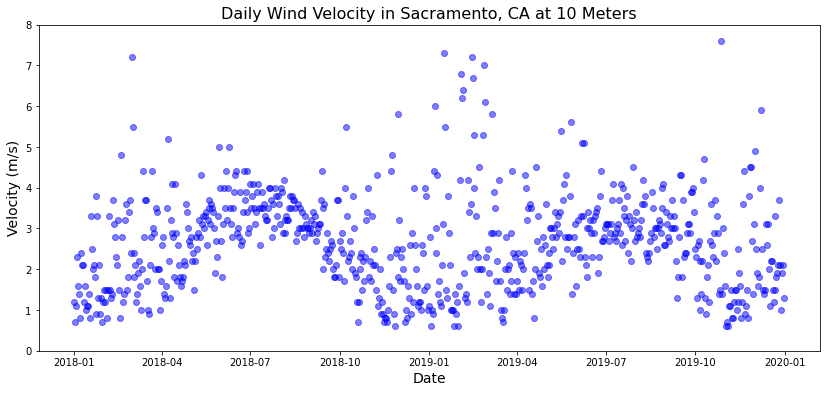

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

windy = ee_array_to_df(wind_sac_poi,['vs'])

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(windy['datetime'], windy['vs'], c = 'blue', alpha = 0.5)
ax.set_title('Daily Wind Velocity in Sacramento, CA at 10 Meters', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Velocity (m/s)', fontsize = 14)
# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET#bands
ax.set_ylim(0, 8)
plt.show()

In [58]:
roi = sac_poi.buffer(1e6)

In [59]:
wind_img = wind.mean()

In [60]:
from IPython.display import Image
url = wind_img.getThumbUrl({
    'min': 0, 'max': 8, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']
})

print(url)
Image(url=url)
# https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acebb2b62ea87dbf2949743b09dea816-71e45ea5299813305ee0bd1f8a1f2b1b:getPixels

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a072b9ebb7fd658ad26994d2ee225bd-212482e0465c4fbd79b73d11383cc815:getPixels


## Filter by Country

In [29]:
# contains administrative boundaries
countries = ee.FeatureCollection('FAO/GAUL/2015/level10').select('ADM0_NAME')
bangladesh = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))
lst_bd = lst_img.clip(bangladesh)
url = lst_bd.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
})

EEException: Collection.loadTable: Collection asset 'FAO/GAUL/2015/level10' not found.